In [2]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [72]:
data_dir = 'data'

width, height = 128, 128
resize = (width, height)
input_shape = (width, height, 1)
num_classes = 2

batch_size = 32
epochs = 10

In [74]:
data = {'x': [], 'y': []}
classes = ['NORMAL', 'COVID19']
le = LabelEncoder()

print("[STATUS] Load images directory")
for dir_path in glob.glob(os.path.join(data_dir, '*')):
    label = os.path.split(dir_path)[-1]

    for image in tqdm(glob.glob(os.path.join(dir_path, '*')), desc='Load ' + dir_path):
        image = cv.imread(image, 0)
        image = cv.resize(image, resize)
        data['x'].append(image)
        data['y'].append(classes.index(label))

print("[STATUS] Load images completed")

[STATUS] Load images directory


Load data\NORMAL: 100%|████████████████████████████████████████████████████████████| 1579/1579 [01:05<00:00, 23.99it/s]

[STATUS] Load images completed


In [75]:
data['x'] = np.array(data['x'], dtype='f') / 255
data['x'] = data['x'].reshape(data['x'].shape[0], width, height, 1)
data['y'] = np.array(data['y'])

In [76]:
dataframe = {'Kelas': classes, 'Jumlah' : pd.value_counts(data['y'])}
pd.DataFrame(dataframe)

,Kelas,Jumlah
0,NORMAL,1579
1,COVID19,229


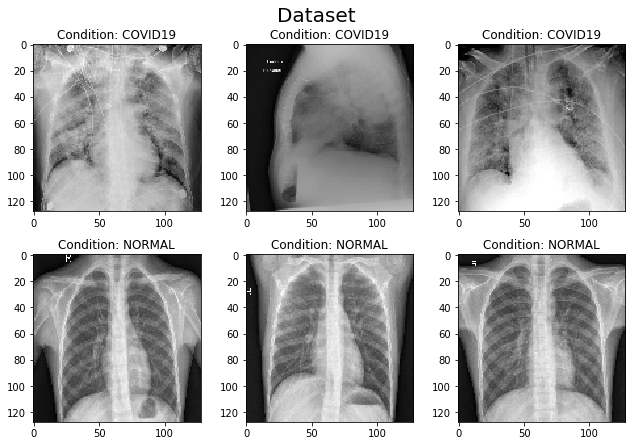

In [77]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))

for i, dir_path in enumerate(glob.glob(os.path.join(data_dir, '*'))):
    label = os.path.split(dir_path)[-1]

    for j, image in enumerate(glob.glob(os.path.join(dir_path, '*'))[:3]):
        image = cv.imread(image, 0)
        image = cv.resize(image, resize)
        ax[i][j].imshow(image, cmap='gray')
        ax[i][j].set_title('Condition: ' + label)

fig.suptitle('Dataset', position=(.5, 1.025), fontsize=20)
fig.tight_layout()
fig.show()

In [78]:
data['train'], data['test'], data['val'] = {}, {}, {}

In [79]:
data['train']['x'], data['test']['x'], data['train']['y'], data['test']['y'] = \
train_test_split(data['x'], data['y'], test_size=0.30, random_state=42)

In [80]:
dataframe = {'': ['train', 'test'], 'total': [len(data['train']['x']), len(data['test']['x'])]}
pd.DataFrame(dataframe)

,,total
0,train,1265
1,test,543


In [81]:
print(pd.value_counts(data['train']['y']))
print(pd.value_counts(data['test']['y']))

0    1091
1     174
dtype: int64
0    488
1     55
dtype: int64


# Over Sampling

In [82]:
over_sampling = RandomOverSampler(random_state=42)
x_train = data['train']['x'].reshape(data['train']['x'].shape[0], width*height)
data['train']['x'], data['train']['y'] = over_sampling.fit_resample(x_train, data['train']['y'])
data['train']['x'] = data['train']['x'].reshape(data['train']['x'].shape[0], width, height, 1)

In [50]:
x_test = data['test']['x'].reshape(data['test']['x'].shape[0], width*height)
data['test']['x'], data['test']['y'] = over_sampling.fit_resample(x_test, data['test']['y'])
data['test']['x'] = data['test']['x'].reshape(data['test']['x'].shape[0], width, height, 1)

# Under Sampling

In [29]:
under_sampling = RandomUnderSampler(random_state=0)
x_train = data['train']['x'].reshape(data['train']['x'].shape[0], width*height)
data['train']['x'], data['train']['y'] = under_sampling.fit_resample(x_train, data['train']['y'])
data['train']['x'] = data['train']['x'].reshape(data['train']['x'].shape[0], width, height, 1)

In [83]:
x_test = data['test']['x'].reshape(data['test']['x'].shape[0], width*height)
data['test']['x'], data['test']['y'] = under_sampling.fit_resample(x_test, data['test']['y'])
data['test']['x'] = data['test']['x'].reshape(data['test']['x'].shape[0], width, height, 1)

In [84]:
print(pd.value_counts(data['train']['y']))
print(pd.value_counts(data['test']['y']))

1    1091
0    1091
dtype: int64
1    55
0    55
dtype: int64


In [85]:
K.clear_session()
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer = Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# checkpoint = ModelCheckpoint(filepath=os.path.join(model_dir, 'best_weights1.hdf5'), save_best_only=True, save_weights_only=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 128)     36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0

In [86]:
history = model.fit(data['train']['x'], data['train']['y'],
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_data=(data['test']['x'], data['test']['y']))

score = model.evaluate(data['test']['x'], data['test']['y'], verbose=0)
print('\nEvaluate')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2182 samples, validate on 110 samples
Epoch 1/10
2182/2182 [==============================] - 37s 17ms/sample - loss: 0.3778 - accuracy: 0.8130 - val_loss: 0.1819 - val_accuracy: 0.9455
Epoch 2/10
2182/2182 [==============================] - 36s 16ms/sample - loss: 0.1510 - accuracy: 0.9473 - val_loss: 0.0744 - val_accuracy: 0.9727
Epoch 3/10
2182/2182 [==============================] - 36s 17ms/sample - loss: 0.1148 - accuracy: 0.9615 - val_loss: 0.0622 - val_accuracy: 0.9545
Epoch 4/10
2182/2182 [==============================] - 36s 17ms/sample - loss: 0.1095 - accuracy: 0.9656 - val_loss: 0.0893 - val_accuracy: 0.9727
Epoch 5/10
2182/2182 [==============================] - 36s 17ms/sample - loss: 0.0724 - accuracy: 0.9739 - val_loss: 0.0840 - val_accuracy: 0.9636
Epoch 6/10
2182/2182 [==============================] - 36s 17ms/sample - loss: 0.0665 - accuracy: 0.9780 - val_loss: 0.0457 - val_accuracy: 0.9818
Epoch 7/10
2182/2182 [==============================] - 36s 17ms/

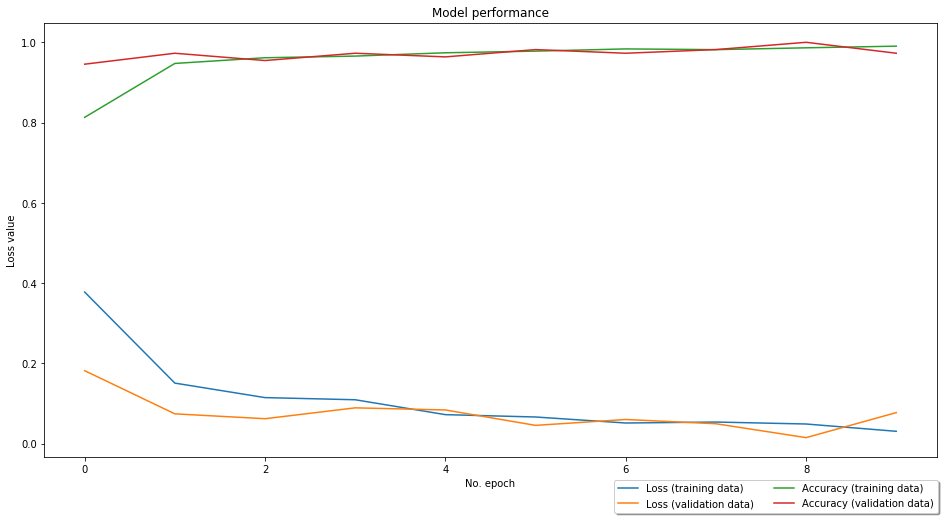

In [87]:
fig = plt.figure(figsize = (16, 8))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.82, -0.04), shadow=True, ncol=2)
plt.show()

In [88]:
pred = model.predict_classes(data['test']['x'])
print("Performance report (test): \n %s \n" %(metrics.classification_report(data['test']['y'], pred)))

Performance report (test): 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        55
           1       0.98      0.96      0.97        55

    accuracy                           0.97       110
   macro avg       0.97      0.97      0.97       110
weighted avg       0.97      0.97      0.97       110
 



In [89]:
model.save('covid_classification_model-acc-97.h5')

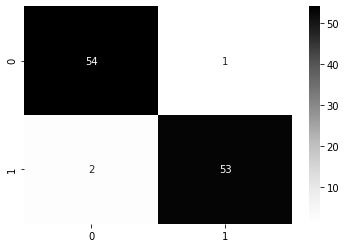

In [92]:
import seaborn as sns

cn = metrics.confusion_matrix(data['test']['y'], pred)
p = sns.heatmap(cn, cmap="Greys", annot=True) #0: Covid ; 1: Normal 

In [1]:
# fig, ax = plt.subplots(2, 5, figsize=(16,8))
# k = 0
# for j in range(len(ax)):
#     for i in range(len(ax[j])):
#         ax[j][i].imshow(data['val']['x'][k].reshape(width, height), cmap='gray')
#         ax[j][i].set_title('Condition: %s\n Prediction: %s' % (CLASS[data['val']['y'][k]], CLASS[predictions[k]]))
#         k +=1

# fig.suptitle('Result Predictions', position=(.5, 1.02), fontsize=20)
# fig.tight_layout()
# fig.show()